In [ ]:
%cd /home/yokoyama/ahar
from types import SimpleNamespace
import sys
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from tqdm import tqdm

sys.path.append(".")
from modules.individual import IndividualDataHandler, IndividualModelFactory, IndividualDataFormat
from modules.utils.logger import logger

: 

In [2]:
gpu = 1
torch.cuda.set_device(gpu)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# prepairing output data dirs
video_dir = os.path.join("/raid6/surgery-video", "test", "001")
video_paths = sorted(glob(os.path.join(video_dir, "*.mp4")))
data_dirs = []
for video_path in video_paths:
    name = os.path.basename(video_path).replace(".mp4", "")
    data_dir = os.path.join("data", "test", "001", name)
    data_dirs.append(data_dir)
    os.makedirs(data_dir, exist_ok=True)
    
config = IndividualDataHandler.get_config("configs/individual/gan.yaml")
test_dataloader = IndividualDataHandler.create_data_loader(data_dirs, config, logger, is_test=True)

gan = IndividualModelFactory.load_model("models/individual", config, device, logger)

2022-10-05 16:40:07,406 => loading pose estimation results from data/test/001/01/pickle/pose.pkl
2022-10-05 16:40:07,435 => creating dataset
100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]
2022-10-05 16:40:11,539 => loading generator models/individual/generator_2x8.pth
2022-10-05 16:40:13,804 => loading discriminator models/individual/discriminator_2x8.pth


In [4]:
D = gan.Discriminator
results = []
with torch.no_grad():
    for frame_nums, pids, kps in tqdm(test_dataloader):
        outputs, fd, ws_d, wt_d = D(kps.to(device))

        fd = fd.cpu().numpy()
        ws_d = ws_d.cpu().numpy()
        wt_d = wt_d.cpu().numpy()
        outputs = outputs.cpu().numpy()
        for i in range(frame_nums.shape[0]):
            results.append({
                IndividualDataFormat.frame_num: frame_nums[i],
                IndividualDataFormat.id: pids[i],
                IndividualDataFormat.feature: fd[i],
                IndividualDataFormat.w_spat: ws_d[i],
                IndividualDataFormat.w_temp: wt_d[i],
                "output": outputs[i]
            })

100%|██████████| 95/95 [00:02<00:00, 38.23it/s]


In [5]:
tsne = TSNE(n_components=2, random_state=64)
features = [data[IndividualDataFormat.feature].ravel() for data in results]
features_reduced = tsne.fit_transform(np.array(features))

/raid6/home/yokoyama/ahar/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/raid6/home/yokoyama/ahar/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


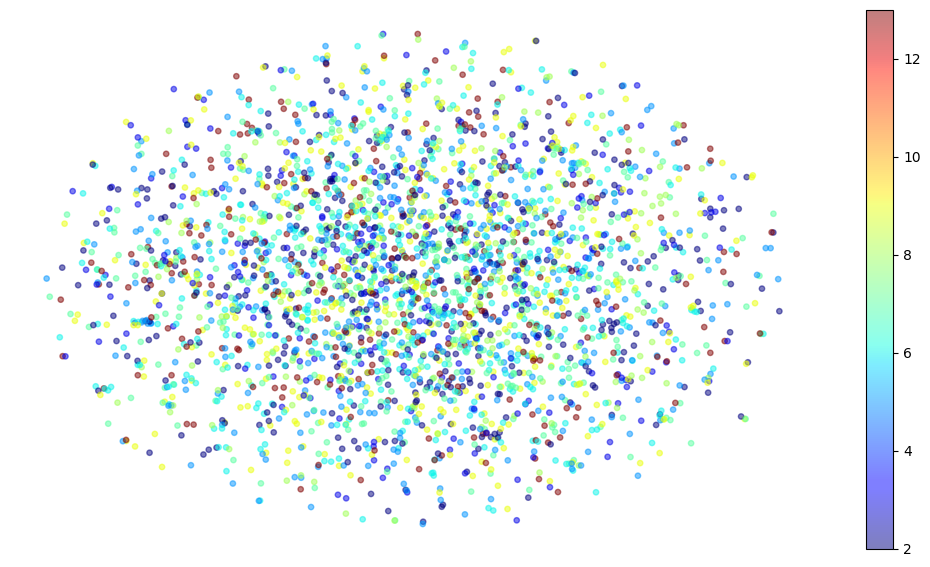

In [6]:
c = [data[IndividualDataFormat.id] for data in results]
plt.figure(figsize=(13, 7))
plt.scatter(
    features_reduced[:, 0],
    features_reduced[:, 1],
    c=c,
    cmap='jet',
    s=15,
    alpha=0.5
)
plt.axis('off')
plt.colorbar()